# Assignment
- Learn about the mathematics of Logistic Regression by watching Aaron Gallant's [video #1](https://www.youtube.com/watch?v=pREaWFli-5I) (12 minutes) & [video #2](https://www.youtube.com/watch?v=bDQgVt4hFgY) (9 minutes).
- Start a clean notebook.
- Do train/validate/test split with the Tanzania Waterpumps data.
- Begin to explore and clean the data. For ideas, refer to [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide),  a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)
- Select different numeric and categorical features. 
- Do one-hot encoding. (Remember it may not work with high cardinality categoricals.)
- Scale features.
- Use scikit-learn for logistic regression.
- Get your validation accuracy score.
- Get and plot your coefficients.
- Submit your predictions to our Kaggle competition.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Begin to visualize the data.
- Try different [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html)
- Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [67]:
# importing data...

import pandas as pd

LOCAL = '../data/tanzania/'

train_features = pd.read_csv(LOCAL + 'train_features.csv')
train_labels = pd.read_csv(LOCAL + 'train_labels.csv')
test_features = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

assert train_features.shape == (59400, 40)
assert train_labels.shape == (59400, 2)
assert test_features.shape == (14358, 40)
assert sample_submission.shape == (14358, 2)

In [68]:
# exploration of train_features...

import pandas_profiling

#train_features.profile_report()

In [69]:
# what does train_labels look like?

train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [70]:
# determining majority class for baseline...

y_train = train_labels['status_group']
y_train.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [71]:
# making baseline model and calculating its accuracy...

from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0] # majority_class is 'functional'
y_pred = [majority_class] * len(y_train) # baseline prediction

accuracy_score(y_train, y_pred)

0.543080808080808

In [72]:
# merging train_features with train_labels to prepare for train/validation
# split on time...

train_merge = train_features.merge(train_labels)

In [73]:
# converting date_recorded to datetime format...

train_merge['date_recorded'] = pd.to_datetime(train_merge['date_recorded'],
                                             infer_datetime_format=True)

test_features['date_recorded'] = pd.to_datetime(test_features[
    'date_recorded'], infer_datetime_format=True)

In [74]:
# doing train/validation split on time...

split_date = train_merge['date_recorded'].quantile(.8)

val_data = train_merge[train_merge['date_recorded'] > split_date].copy()
train_data = train_merge[train_merge['date_recorded'] <= split_date].copy()

train_data.shape, val_data.shape

((47553, 41), (11847, 41))

In [75]:
# initial exploration of categorical features...

train_data.describe(exclude = 'number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
recorded_by,47553,1,GeoData Consultants Ltd,47553,NaN,NaN
public_meeting,45514,2,True,41249,NaN,NaN
permit,45449,2,True,30051,NaN,NaN
status_group,47553,3,functional,25119,NaN,NaN
source_class,47553,3,groundwater,36538,NaN,NaN
quantity_group,47553,5,enough,27175,NaN,NaN
quantity,47553,5,enough,27175,NaN,NaN
management_group,47553,5,user-group,42684,NaN,NaN
quality_group,47553,6,good,40066,NaN,NaN
waterpoint_type_group,47553,6,communal standpipe,25371,NaN,NaN


In [76]:
# dropping recorded_by since it only has one value...

train_data = train_data.drop(columns=['recorded_by'])
val_data = val_data.drop(columns=['recorded_by'])
test_features = test_features.drop(columns=['recorded_by'])

# dropping quantity_group since profiler says it is a recoding of quantity...

train_data = train_data.drop(columns=['quantity_group'])
val_data = val_data.drop(columns=['quantity_group'])
test_features = test_features.drop(columns=['quantity_group'])

# dropping num_private since it almost all zeros...

train_data = train_data.drop(columns=['num_private'])
val_data = val_data.drop(columns=['num_private'])
test_features = test_features.drop(columns=['num_private'])

# dropping waterpoint_type_group since waterpoint_type makes it redundant...

train_data = train_data.drop(columns=['waterpoint_type_group'])
val_data = val_data.drop(columns=['waterpoint_type_group'])
test_features = test_features.drop(columns=['waterpoint_type_group'])

# dropping payment_type since payment makes it redundant...

train_data = train_data.drop(columns=['payment_type'])
val_data = val_data.drop(columns=['payment_type'])
test_features = test_features.drop(columns=['payment_type'])

# dropping source_type since source makes it redundant...

train_data = train_data.drop(columns=['source_type'])
val_data = val_data.drop(columns=['source_type'])
test_features = test_features.drop(columns=['source_type'])

# dropping quality_group since water_quality makes it redundant...

train_data = train_data.drop(columns=['quality_group'])
val_data = val_data.drop(columns=['quality_group'])
test_features = test_features.drop(columns=['quality_group'])

# dropping source_class since source makes it redundant...

train_data = train_data.drop(columns=['source_class'])
val_data = val_data.drop(columns=['source_class'])
test_features = test_features.drop(columns=['source_class'])

In [77]:
# encoding some categorical variables as ordinals...

train_data['public_meeting'] = train_data['public_meeting'].replace(
    {True: 1, False: 0})
train_data['permit'] = train_data['permit'].replace(
    {True: 1, False: 0})

val_data['public_meeting'] = val_data['public_meeting'].replace(
    {True: 1, False: 0})
val_data['permit'] = val_data['permit'].replace(
    {True: 1, False: 0})

test_features['public_meeting'] = test_features['public_meeting'].replace(
    {True: 1, False: 0})
test_features['permit'] = test_features['permit'].replace(
    {True: 1, False: 0})

In [78]:
# taking another look at categorical features before one-hot encoding...

train_data.describe(exclude = 'number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
status_group,47553,3,functional,25119,NaN,NaN
quantity,47553,5,enough,27175,NaN,NaN
management_group,47553,5,user-group,42684,NaN,NaN
payment,47553,7,never pay,21892,NaN,NaN
waterpoint_type,47553,7,communal standpipe,20294,NaN,NaN
extraction_type_class,47553,7,gravity,18594,NaN,NaN
water_quality,47553,8,soft,40066,NaN,NaN
basin,47553,9,Lake Victoria,9614,NaN,NaN
source,47553,10,shallow well,15625,NaN,NaN
scheme_management,43914,11,VWC,31104,NaN,NaN


In [79]:
# one-hot encoding categorical features with a cardinality of 10 or lower...

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

encoded = encoder.fit_transform(train_data[
    ['quantity',
     'management_group',
     'waterpoint_type',
     'payment',
     'extraction_type_class',
     'water_quality',
     'basin',
     'source']])
train_data = train_data.join(encoded)

encoded = encoder.fit_transform(val_data[
    ['quantity',
     'management_group',
     'waterpoint_type',
     'payment',
     'extraction_type_class',
     'water_quality',
     'basin',
     'source']])
val_data = val_data.join(encoded)

encoded = encoder.fit_transform(test_features[
    ['quantity',
     'management_group',
     'waterpoint_type',
     'payment',
     'extraction_type_class',
     'water_quality',
     'basin',
     'source']])
test_features = test_features.join(encoded)

In [80]:
# fixing zeros in place of NaNs...

import numpy as np

train_data['amount_tsh'] = train_data['amount_tsh'].replace(0, np.nan)
train_data['construction_year'] = train_data[
    'construction_year'].replace(0, np.nan)
train_data['gps_height'] = train_data['gps_height'].replace(0, np.nan)
train_data['population'] = train_data['population'].replace(0, np.nan)

val_data['amount_tsh'] = val_data['amount_tsh'].replace(0, np.nan)
val_data['construction_year'] = val_data[
    'construction_year'].replace(0, np.nan)
val_data['gps_height'] = val_data['gps_height'].replace(0, np.nan)
val_data['population'] = val_data['population'].replace(0, np.nan)

test_features['amount_tsh'] = test_features['amount_tsh'].replace(0, np.nan)
test_features['construction_year'] = test_features[
    'construction_year'].replace(0, np.nan)
test_features['gps_height'] = test_features['gps_height'].replace(0, np.nan)
test_features['population'] = test_features['population'].replace(0, np.nan)

In [81]:
# replacing NaNs with means...

train_data['amount_tsh'] = train_data['amount_tsh'].fillna(
    train_data['amount_tsh'].mean())
train_data['gps_height'] = train_data['gps_height'].fillna(
    train_data['gps_height'].mean())
train_data['population'] = train_data['population'].fillna(
    train_data['population'].mean())
train_data['public_meeting'] = train_data['public_meeting'].fillna(
    train_data['public_meeting'].mean())
train_data['permit'] = train_data['permit'].fillna(
    train_data['permit'].mean())
train_data['construction_year'] = train_data['construction_year'].fillna(
    train_data['construction_year'].mean())

val_data['amount_tsh'] = val_data['amount_tsh'].fillna(
    val_data['amount_tsh'].mean())
val_data['gps_height'] = val_data['gps_height'].fillna(
    val_data['gps_height'].mean())
val_data['population'] = val_data['population'].fillna(
    val_data['population'].mean())
val_data['public_meeting'] = val_data['public_meeting'].fillna(
    val_data['public_meeting'].mean())
val_data['permit'] = val_data['permit'].fillna(
    val_data['permit'].mean())
val_data['construction_year'] = val_data['construction_year'].fillna(
    val_data['construction_year'].mean())

test_features['amount_tsh'] = test_features['amount_tsh'].fillna(
    test_features['amount_tsh'].mean())
test_features['gps_height'] = test_features['gps_height'].fillna(
    test_features['gps_height'].mean())
test_features['population'] = test_features['population'].fillna(
    test_features['population'].mean())
test_features['public_meeting'] = test_features['public_meeting'].fillna(
    test_features['public_meeting'].mean())
test_features['permit'] = test_features['permit'].fillna(
    test_features['permit'].mean())
test_features['construction_year'] = test_features['construction_year'].fillna(
    test_features['construction_year'].mean())

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Train Accuracy Score: 0.7260950938952326 

Validation Accuracy Score: 0.7334346247995273 



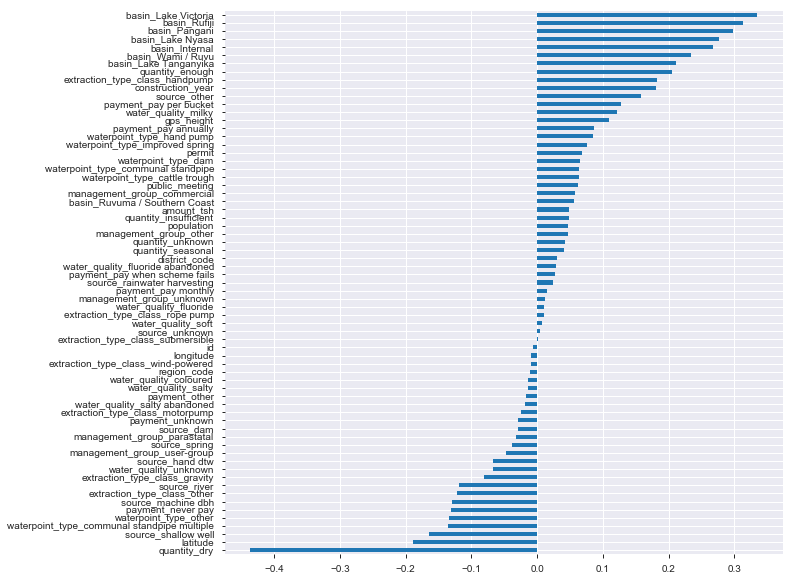

In [144]:
# scaling features, doing logistic regression, calculating accuracy score,
# and plotting model coefficients...

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

target = 'status_group'
train_features = train_data.select_dtypes(include=np.number).columns.tolist()
val_features = train_features
val_features.remove('source_lake')
val_features.remove('basin_Lake Rukwa')

X_train = train_data[train_features]
y_train = train_data[target]

X_val = val_data[val_features]
y_val = val_data[target]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
    
model = LogisticRegression(solver='lbfgs', multi_class='auto',
                           max_iter=10000)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

print('Train Accuracy Score:', accuracy_score(y_train, y_pred_train), '\n')

print('Validation Accuracy Score:', accuracy_score(y_val, y_pred_val), '\n')

plt.figure(figsize=(10, 10))
coefficients = pd.Series(model.coef_[0], train_features)
coefficients.sort_values().plot.barh();

In [152]:
X_test = test_features[train_features]

X_test = scaler.transform(X_test)

y_test_train = model.predict(X_test)

submission = pd.DataFrame({'id': test_features['id'].array, 'status_group': y_test_train})

submission.to_csv('nathan_van_wyck_submission.csv', index=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
